# Análise de Dados de tdm_25_fit com Diferentes Parâmetros

In [57]:
from datetime import datetime
import pandas as pd

def get_track_data(filename):
    file = open(filename,'r')
    lines = file.readlines()

    tempo_utc_list = list()
    tempo_seconds_list = []
    ra = list()
    dec = list()

    break_lines = lines.count('\n')

    for i in range(break_lines):
        lines.remove('\n')

    for i, line in enumerate(lines):
        line = line.replace('\n','').replace('=','')
        lines[i] = line
        splitted_line = line.split(' ')
        tempo_utc = datetime.strptime(splitted_line[2],'%Y-%m-%dT%H:%M:%S.%f')
        tempo_seconds = tempo_utc.timestamp()
        if tempo_utc_list.count(tempo_utc) == 0:
            tempo_utc_list.append(tempo_utc)
            tempo_seconds_list.append(tempo_seconds)
        if splitted_line[0] == 'ANGLE_1':
            ra.append(float(splitted_line[3]))
        else:
            dec.append(float(splitted_line[3]))
    
    dados = {
        'Tempo (UTC)':tempo_utc_list,
        'Tempo[s]': tempo_seconds_list,
        'RA[deg]':ra,
        'DEC[deg]':dec
        }
    df = pd.DataFrame(data=dados)
    return df

In [58]:
import numpy as np

def interpolar_dados(dados_originais : pd.DataFrame, dados_referencia : pd.DataFrame) -> pd.DataFrame:
    # Interpolação dos dados de 1.2 FOV:
    p_ra_fit = np.polynomial.polynomial.Polynomial.fit(dados_originais['Tempo[s]'],dados_originais['RA[deg]'],3)
    p_dec_fit = np.polynomial.polynomial.Polynomial.fit(dados_originais['Tempo[s]'],dados_originais['DEC[deg]'],3)

    ra_fit = []
    dec_fit = []
    desvio_ra = []
    desvio_dec = []
    for index, row in dados_referencia.iterrows():
        if row['Tempo[s]'] <= dados_originais['Tempo[s]'].max() :
            aux_ra = p_ra_fit(row['Tempo[s]'])
            aux_dec = p_dec_fit(row['Tempo[s]'])
            ra_fit.append(aux_ra)
            dec_fit.append(aux_dec)
            desvio_ra.append(100*np.abs((row['RA[deg]']-aux_ra)/row['RA[deg]']))
            desvio_dec.append(100*np.abs((row['DEC[deg]']-aux_dec)/row['DEC[deg]']))

        # aux_ra = p_ra_fit(row['Tempo[s]'])
        # aux_dec = p_dec_fit(row['Tempo[s]'])
        # ra_fit.append(aux_ra)
        # dec_fit.append(aux_dec)
        # desvio_ra.append(100*np.abs((row['RA[deg]']-aux_ra)/row['RA[deg]']))
        # desvio_dec.append(100*np.abs((row['DEC[deg]']-aux_dec)/row['DEC[deg]']))

    dados_fit = {
        'Tempo (UTC)': dados_referencia[dados_referencia['Tempo[s]'] <= dados_originais['Tempo[s]'].max()]['Tempo (UTC)'],
        'Tempo[s]': dados_referencia[dados_referencia['Tempo[s]'] <= dados_originais['Tempo[s]'].max()]['Tempo[s]'],
        # 'Tempo (UTC)': dados_referencia['Tempo (UTC)'],
        # 'Tempo[s]': dados_referencia['Tempo[s]'],
        'RA[deg]':ra_fit,
        'DEC[deg]':dec_fit,
        'Desvio RA (%)': desvio_ra,
        'Desvio DEC (%)': desvio_dec
    }

    dados_originais_fit = pd.DataFrame(data = dados_fit)
    return dados_originais_fit

## Análise do Threshold

Para essa análise, considerou-se aliviar o threshold para 2.5

In [59]:
tdm_aldoria = get_track_data('Dados\\TDM_7646.txt')
tdm_30 = get_track_data('Dados\\TDM\\Threshold\\TDM-Saipher-30.txt')
tdm_25 = get_track_data('Dados\\TDM\\Threshold\\TDM-Saipher-25.txt')


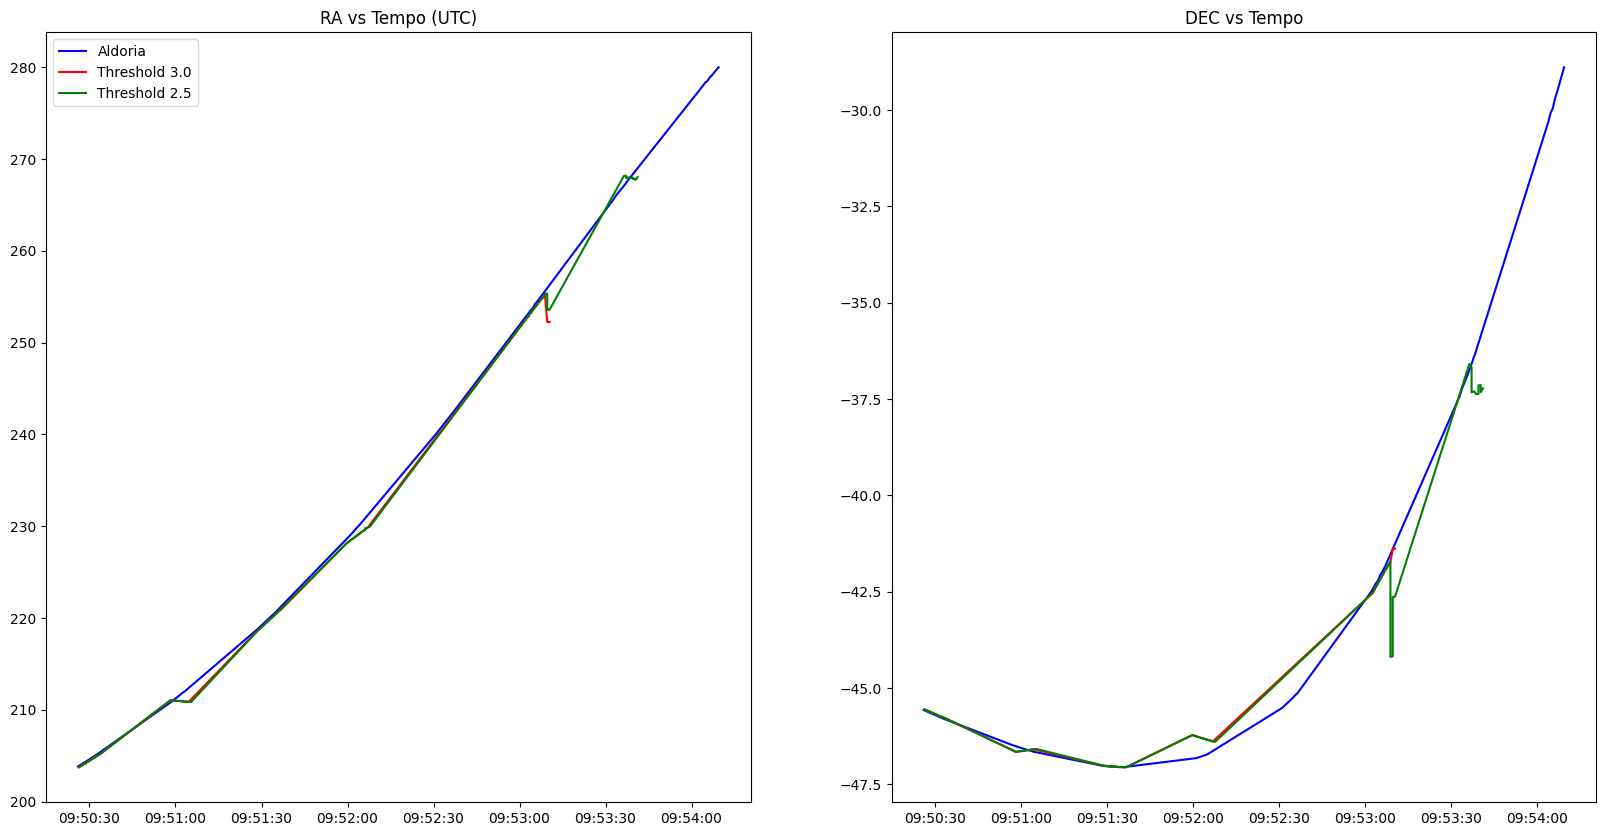

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],color='blue')
plt.plot(tdm_30['Tempo (UTC)'],tdm_30['RA[deg]'],color='red')
plt.plot(tdm_25['Tempo (UTC)'],tdm_25['RA[deg]'],color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo (UTC)')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['DEC[deg]'],color='blue')
plt.plot(tdm_30['Tempo (UTC)'],tdm_30['DEC[deg]'],color='red')
plt.plot(tdm_25['Tempo (UTC)'],tdm_25['DEC[deg]'],color='green')
plt.title('DEC vs Tempo')
plt.show()

In [61]:
# Interpolação dos dados de 3.0 Threshold:
tdm_30_fit = interpolar_dados(tdm_30,tdm_aldoria)

# Interpolação dos dados de 2.5 Threshold:
tdm_25_fit = interpolar_dados(tdm_25,tdm_aldoria)

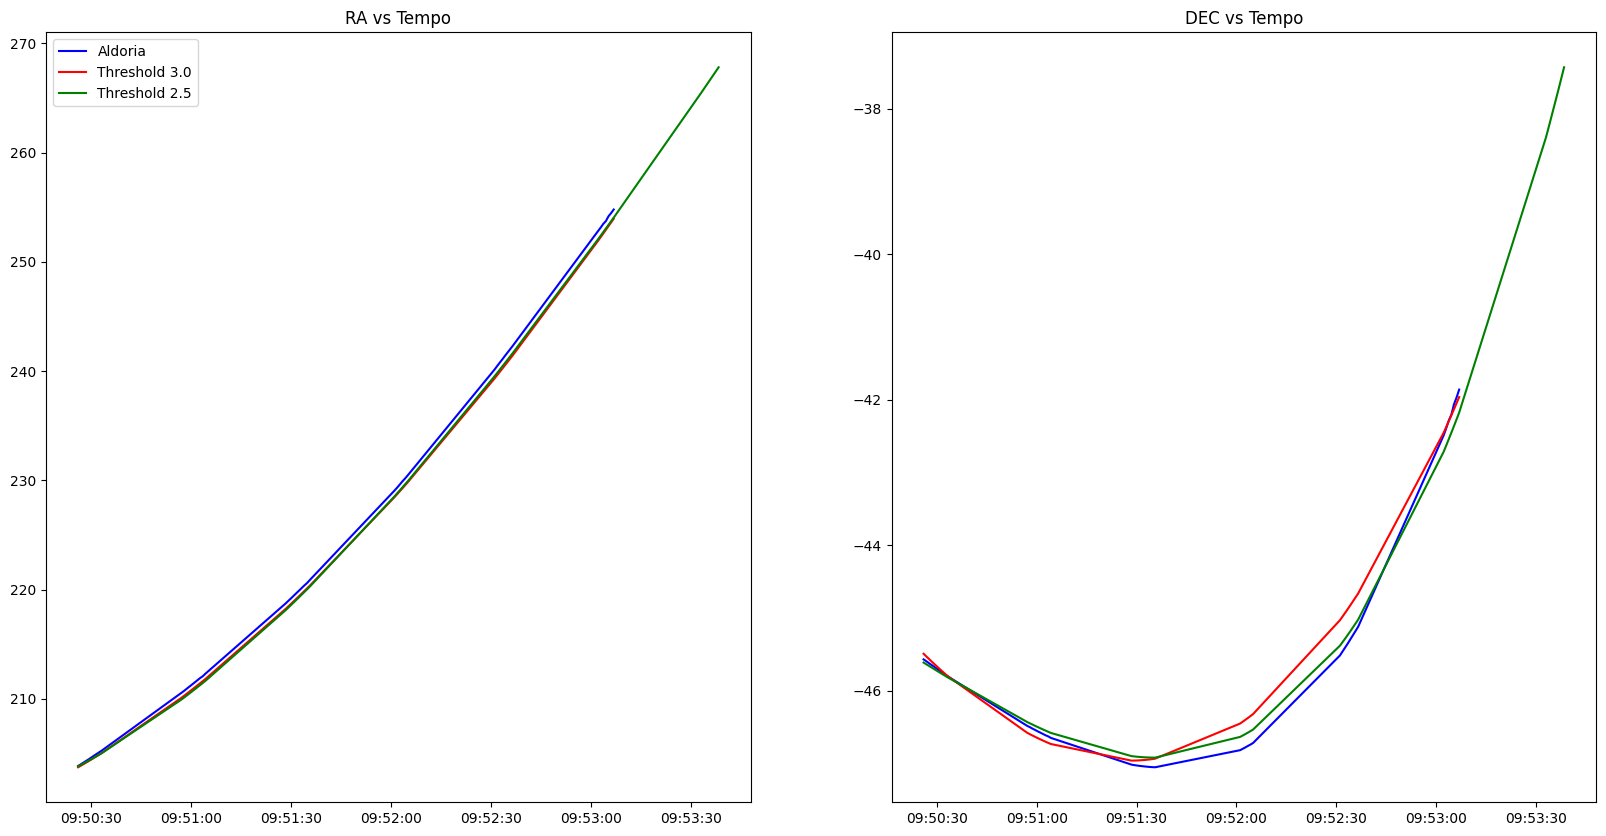

In [62]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
t_12_max = (tdm_30_fit['Tempo[s]']).max()
filter = (tdm_aldoria['Tempo[s]'] <= t_12_max)
plt.plot(tdm_aldoria[filter]['Tempo (UTC)'],tdm_aldoria[filter]['RA[deg]'],color='blue')
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['RA[deg]'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['RA[deg]'],color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria[filter]['Tempo (UTC)'],tdm_aldoria[filter]['DEC[deg]'],color='blue')
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['DEC[deg]'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['DEC[deg]'],color='green')
plt.title('DEC vs Tempo')
plt.show()

In [63]:
import numpy as np

#Desvios para RA
median_ra = np.median(tdm_30_fit['Desvio RA (%)'])
mean_ra = np.mean(tdm_30_fit['Desvio RA (%)'])
std_ra = np.std(tdm_30_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(tdm_30_fit['Desvio DEC (%)'])
mean_dec = np.mean(tdm_30_fit['Desvio DEC (%)'])
std_dec = np.std(tdm_30_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': tdm_30_fit['Desvio RA (%)'].max(),
    'Máximo erro DEC (%)': tdm_30_fit['Desvio DEC (%)'].max()
}

stats = pd.DataFrame(index = ['Threshold 3.0'] ,data = dados_stats)

#Desvios para RA
median_ra = np.median(tdm_25_fit['Desvio RA (%)'])
mean_ra = np.mean(tdm_25_fit['Desvio RA (%)'])
std_ra = np.std(tdm_25_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(tdm_25_fit['Desvio DEC (%)'])
mean_dec = np.mean(tdm_25_fit['Desvio DEC (%)'])
std_dec = np.std(tdm_25_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': tdm_25_fit['Desvio RA (%)'].max(),
    'Máximo erro DEC (%)': tdm_25_fit['Desvio DEC (%)'].max()
}

stats = stats._append(dados_stats,ignore_index=True)
stats.index = ['Threshold 3.0', 'Threshold 2.5']

stats.head()

,Média RA (%),Média DEC (%),Mediana RA (%),Mediana DEC (%),Desvio Padrão RA (%),Desvio Padrão DEC (%),Máximo erro RA (%),Máximo erro DEC (%)
Threshold 3.0,0.240654,0.359742,0.232041,0.195481,0.089714,0.360113,0.358965,1.065364
Threshold 2.5,0.218570,0.583027,0.267429,0.269143,0.096591,0.850777,0.310799,3.042459


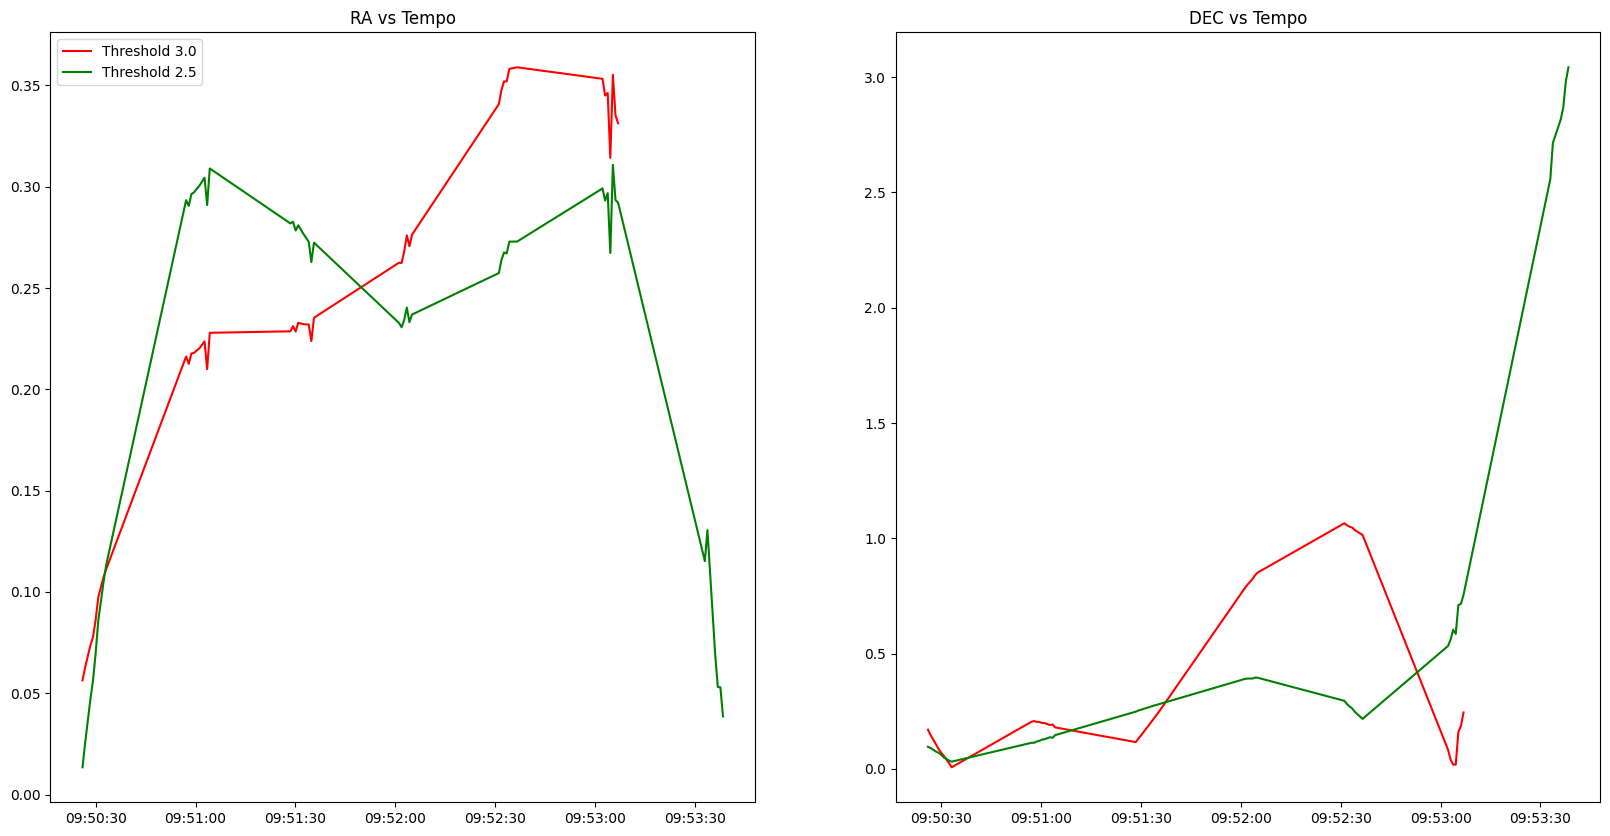

In [64]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio RA (%)'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio RA (%)'],color='green')
plt.legend(['Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio DEC (%)'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio DEC (%)'],color='green')
plt.title('DEC vs Tempo')
plt.show()

## Análise de FOV Parameter

Nessa análise, alterou-se o parâmetro multiplicador do FOV para 1.5 e a área de procura de estrelas no Gaia passou a ser retangular.

In [65]:
tdm_aldoria = get_track_data('Dados\\TDM_7646.txt')
tdm_30 = get_track_data('Dados\\TDM\\Field-Of-View\\TDM-Saipher-15.txt')
tdm_25 = get_track_data('Dados\\TDM\\Field-Of-View\\TDM-Saipher-15-25.txt')


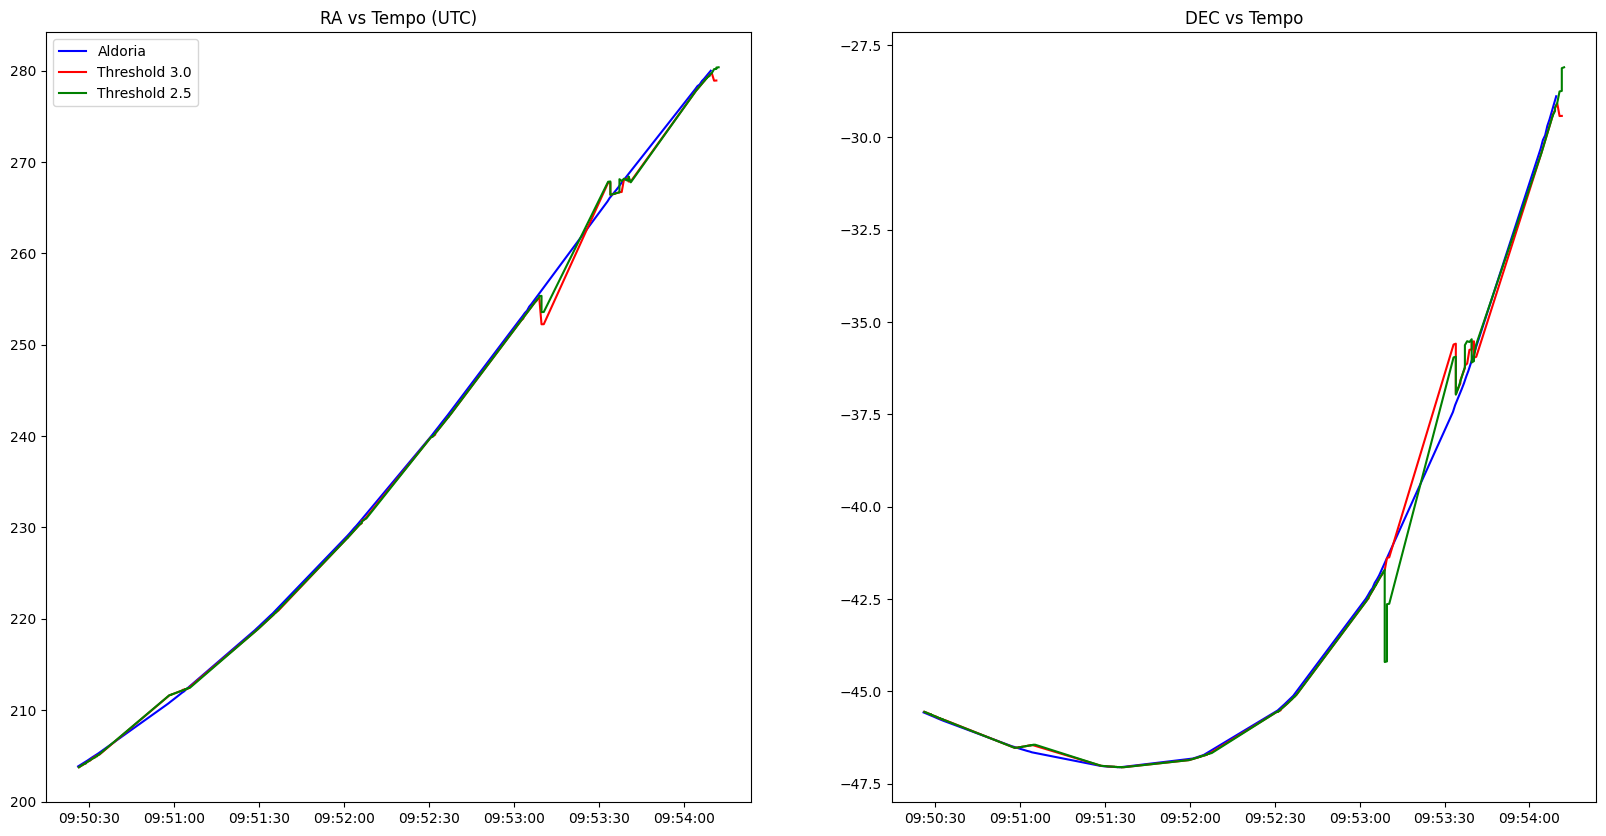

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['RA[deg]'],color='blue')
plt.plot(tdm_30['Tempo (UTC)'],tdm_30['RA[deg]'],color='red')
plt.plot(tdm_25['Tempo (UTC)'],tdm_25['RA[deg]'],color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo (UTC)')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria['Tempo (UTC)'],tdm_aldoria['DEC[deg]'],color='blue')
plt.plot(tdm_30['Tempo (UTC)'],tdm_30['DEC[deg]'],color='red')
plt.plot(tdm_25['Tempo (UTC)'],tdm_25['DEC[deg]'],color='green')
plt.title('DEC vs Tempo')
plt.show()

In [67]:
# Interpolação dos dados de 3.0 Threshold:
tdm_30_fit = interpolar_dados(tdm_30,tdm_aldoria)

# Interpolação dos dados de 2.5 Threshold:
tdm_25_fit = interpolar_dados(tdm_25,tdm_aldoria)

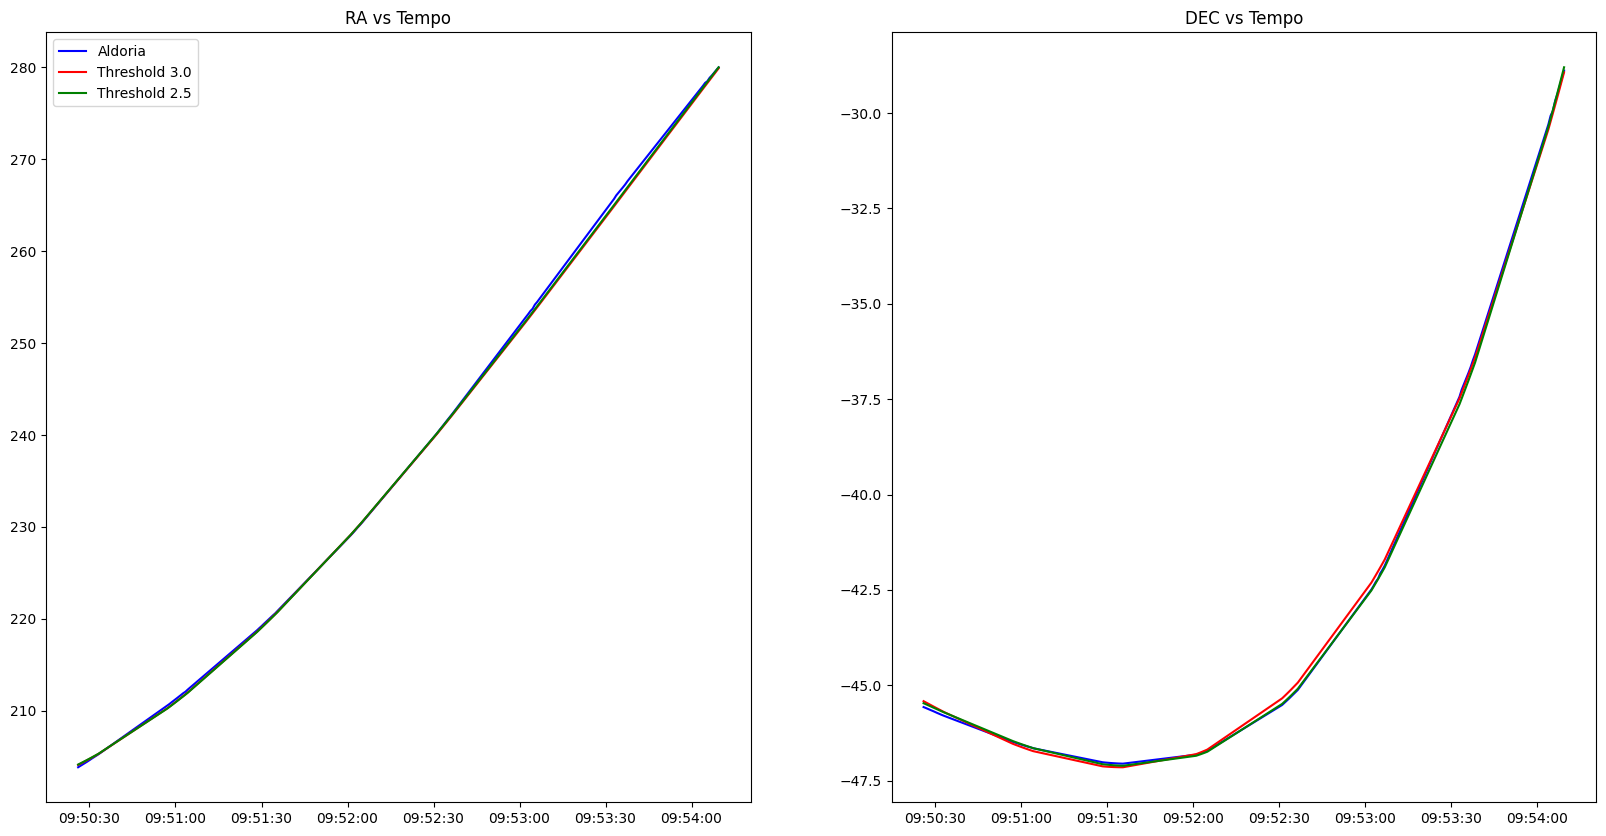

In [68]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
t_12_max = (tdm_30_fit['Tempo[s]']).max()
filter = (tdm_aldoria['Tempo[s]'] <= t_12_max)
plt.plot(tdm_aldoria[filter]['Tempo (UTC)'],tdm_aldoria[filter]['RA[deg]'],color='blue')
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['RA[deg]'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['RA[deg]'],color='green')
plt.legend(['Aldoria','Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm_aldoria[filter]['Tempo (UTC)'],tdm_aldoria[filter]['DEC[deg]'],color='blue')
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['DEC[deg]'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['DEC[deg]'],color='green')
plt.title('DEC vs Tempo')
plt.show()

In [69]:
import numpy as np

#Desvios para RA
median_ra = np.median(tdm_30_fit['Desvio RA (%)'])
mean_ra = np.mean(tdm_30_fit['Desvio RA (%)'])
std_ra = np.std(tdm_30_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(tdm_30_fit['Desvio DEC (%)'])
mean_dec = np.mean(tdm_30_fit['Desvio DEC (%)'])
std_dec = np.std(tdm_30_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': tdm_30_fit['Desvio RA (%)'].max(),
    'Máximo erro DEC (%)': tdm_30_fit['Desvio DEC (%)'].max()
}

stats = pd.DataFrame(index = ['Threshold 3.0'] ,data = dados_stats)

#Desvios para RA
median_ra = np.median(tdm_25_fit['Desvio RA (%)'])
mean_ra = np.mean(tdm_25_fit['Desvio RA (%)'])
std_ra = np.std(tdm_25_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(tdm_25_fit['Desvio DEC (%)'])
mean_dec = np.mean(tdm_25_fit['Desvio DEC (%)'])
std_dec = np.std(tdm_25_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': tdm_25_fit['Desvio RA (%)'].max(),
    'Máximo erro DEC (%)': tdm_25_fit['Desvio DEC (%)'].max()
}

stats = stats._append(dados_stats,ignore_index=True)
stats.index = ['Threshold 3.0', 'Threshold 2.5']

stats.head()

,Média RA (%),Média DEC (%),Mediana RA (%),Mediana DEC (%),Desvio Padrão RA (%),Desvio Padrão DEC (%),Máximo erro RA (%),Máximo erro DEC (%)
Threshold 3.0,0.114326,0.244474,0.075695,0.222996,0.087056,0.121273,0.326517,0.499846
Threshold 2.5,0.101367,0.151548,0.078566,0.105596,0.076056,0.157496,0.274815,0.620978


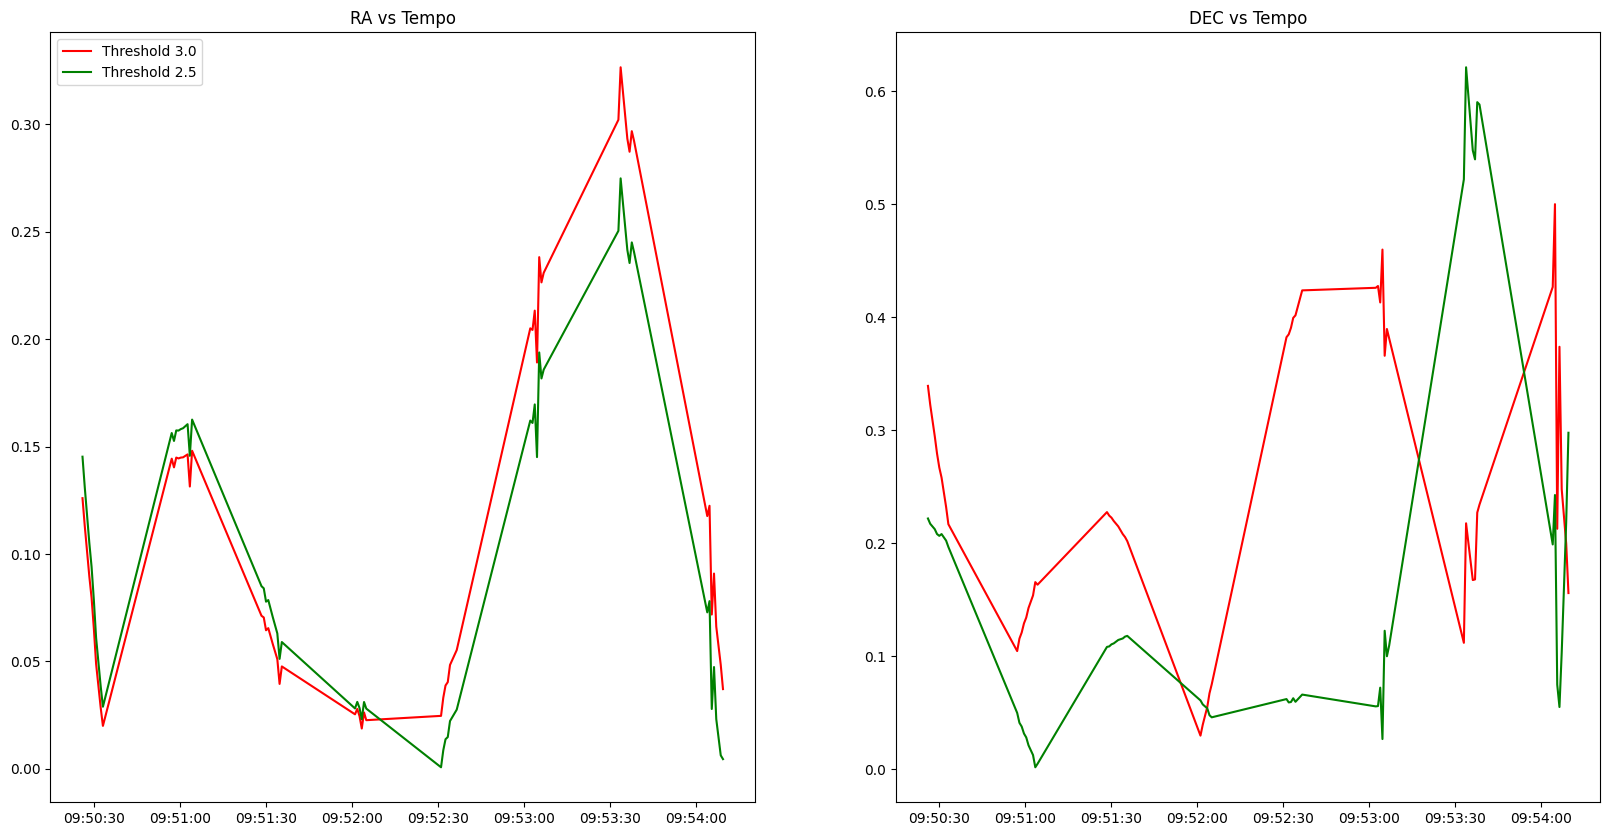

In [70]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio RA (%)'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio RA (%)'],color='green')
plt.legend(['Threshold 3.0', 'Threshold 2.5'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm_30_fit['Tempo (UTC)'],tdm_30_fit['Desvio DEC (%)'],color='red')
plt.plot(tdm_25_fit['Tempo (UTC)'],tdm_25_fit['Desvio DEC (%)'],color='green')
plt.title('DEC vs Tempo')
plt.show()

Agora, considerando o parâmetro como 2.0